<img src='https://unlearning-challenge.github.io/Unlearning-logo.png' width='100px'>

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [1]:
import os
import requests
import numpy as np
#import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CPU


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [2]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [3]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

Let us show some of the training images, just for fun.

In [4]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

NameError: name 'plt' is not defined

We'll now compute the model's accuracy on the train and test set.


In [5]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm

In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm _unlearning by fine-tuning_. It starts from the pre-trained model and optimizes it for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient, and we don't expect it to work very well for most metrics.

To make a new entry in the competition, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

In [10]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        total_batches = len(retain)
        print("Epoch:", _ + 1)
        for i, (inputs, targets) in enumerate(retain, start=1):
            print(f"{i}/{total_batches}", end="\r", flush=True)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [11]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning(ft_model, retain_loader, forget_loader, test_loader)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


# SimPO

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import cycle

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def unlearning_simnpo(
    net: nn.Module,
    retain: torch.utils.data.DataLoader,
    forget: torch.utils.data.DataLoader,
    validation: torch.utils.data.DataLoader,
    epochs: int = 5,
    alpha: float = 0.8,   # weight for retain CE
    beta: float = 5.0,   # sharpness in SimNPO
    delta: float = 0.3,   # margin / tolerance
    save_path: str | None = None,
):
    """
    Unlearning by SimNPO-style finetuning.

    Args:
      net: nn.Module, pre-trained model to unlearn
      retain: DataLoader over retain set
      forget: DataLoader over forget set
      validation: DataLoader over validation set (for reporting only)
      epochs: number of epochs
      alpha: weight for retain CE term
      beta: SimNPO sharpness (usually 5–10)
      delta: SimNPO margin (0.1–0.3 is typical)
      save_path: if not None, save model weights here at the end

    Returns:
      net: updated (unlearned) model
    """
    net = net.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # we'll loop forever over the forget loader so every retain batch gets a forget batch
    forget_iter = cycle(forget)

    net.train()
    for ep in range(epochs):
        total_batches = len(retain)
        print(f"Epoch: {ep + 1}")
        for i, (x_ret, y_ret) in enumerate(retain, start=1):
            x_for, y_for = next(forget_iter)

            x_ret, y_ret = x_ret.to(DEVICE), y_ret.to(DEVICE)
            x_for, y_for = x_for.to(DEVICE), y_for.to(DEVICE)

            optimizer.zero_grad()

            # 1) retain term (normal CE) --------------------------------------
            out_ret = net(x_ret)
            loss_retain = criterion(out_ret, y_ret)

            # 2) forget term (SimNPO) -----------------------------------------
            out_for = net(x_for)  # logits on forget
            # log p(y|x)
            logp_for = F.log_softmax(out_for, dim=1).gather(
                1, y_for.view(-1, 1)
            ).squeeze(1)  # [B]
            # SimNPO loss: -(2/β) * log σ( -β*logp - δ )
            s = -beta * logp_for - delta
            loss_forget = -(2.0 / beta) * torch.log(torch.sigmoid(s) + 1e-12).mean()

            # 3) total ---------------------------------------------------------
            loss = loss_forget + alpha * loss_retain
            loss.backward()
            optimizer.step()

            # same progress style as your original ft code
            print(f"{i}/{total_batches}", end="\r", flush=True)

        scheduler.step()

    net.eval()

    return net

In [31]:
simnpo_model = resnet18(weights=None, num_classes=10)
simnpo_model.load_state_dict(weights_pretrained)
simnpo_model.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
simnpo_model = unlearning(simnpo_model, retain_loader, forget_loader, test_loader)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


We have now an unlearned model `ft_model`. Besides the forgetting quality (which we'll discuss in the next section), a good unlearning algorithm should retain as much as possible the accuracy on the retain and test set.

To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [12]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 98.5%
Test set accuracy: 83.2%


# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [ ]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

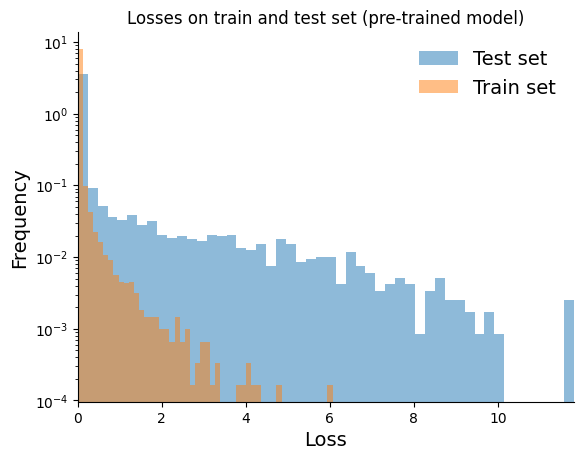

In [ ]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last section of this notebook for additional discussion and for computing that reference point.

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [ ]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.579 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [ ]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [ ]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.512 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

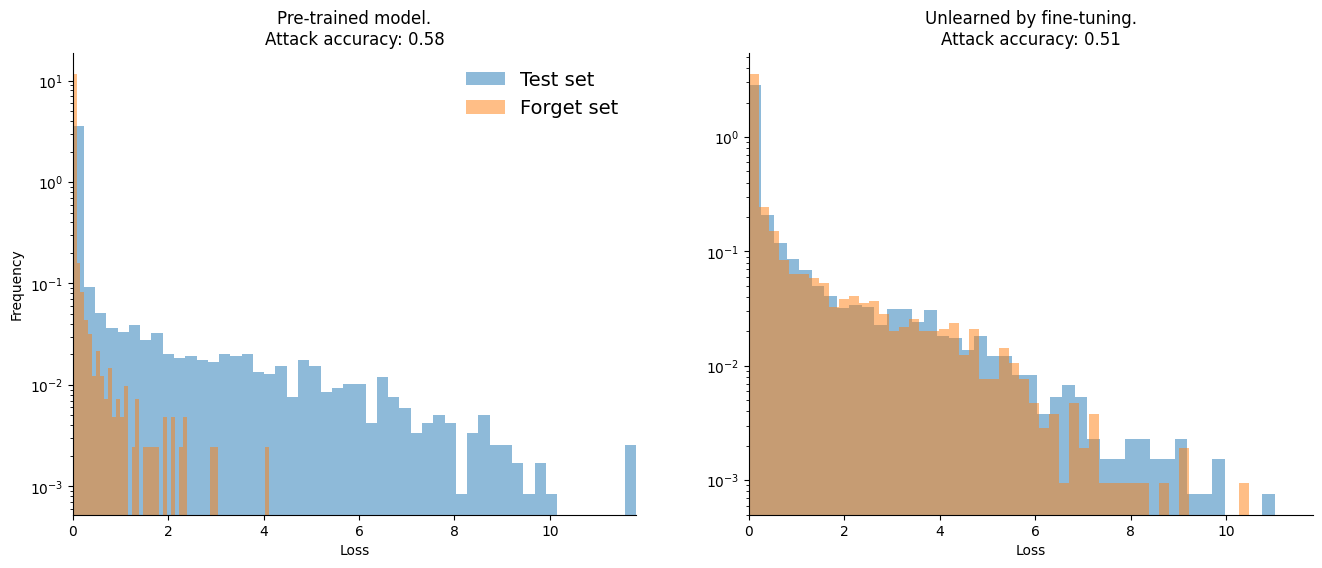

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [20]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


# Influence Functions Approximation: Metric


In [32]:
import torch
import torch.nn.functional as F

# =========================================================
# ASSUMPTIONS:
#   model         -> full-data model (trained on retain + forget)
#   ft_model      -> unlearned model (your method)
#   retrain_model -> retain-only retrain (ground truth counterfactual)
#   forget_loader -> DataLoader over FORGET set
# =========================================================

DEVICE = next(model.parameters()).device
criterion = torch.nn.CrossEntropyLoss(reduction='mean')


# ---------------- helpers ----------------
def flat_params(m: torch.nn.Module) -> torch.Tensor:
    return torch.cat([p.detach().reshape(-1) for p in m.parameters() if p.requires_grad])

def per_sample_grad(model, x, y, loss_fn):
    """
    ∇θ ℓ(x, y; θ) at current params of `model`, returned flat.
    """
    model.zero_grad(set_to_none=True)
    out  = model(x)
    loss = loss_fn(out, y)
    grads = torch.autograd.grad(
        loss,
        [p for p in model.parameters() if p.requires_grad],
        retain_graph=False,
        create_graph=False,
    )
    return torch.cat([g.reshape(-1) for g in grads])


# =========================================================
# 1. parameter directions
# =========================================================
theta_full = flat_params(model)            # θ_full  (saw forget)
theta_unl  = flat_params(simnpo_model)         # θ_unl   (your unlearned)
theta_ret  = flat_params(rt_model)    # θ_ret   (retain-only retrain)

delta_true = (theta_ret - theta_full).to(DEVICE)   # what SHOULD happen if F is gone
delta_unl  = (theta_unl - theta_full).to(DEVICE)   # what DID happen in your unlearning

delta_true_norm = delta_true.norm()
delta_unl_norm  = delta_unl.norm()

print("||delta_true||:", float(delta_true_norm))
print("||delta_unl|| :", float(delta_unl_norm))

# =========================================================
# 2. per-forget-sample projections
# =========================================================
influence_true_list = []   # g_i · delta_true
influence_unl_list  = []   # g_i · delta_unl
leakage_list        = []

eps = 1e-8

for xb, yb in forget_loader:
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)

    for i in range(xb.size(0)):
        xi = xb[i:i+1]
        yi = yb[i:i+1]

        g_i = per_sample_grad(model, xi, yi, criterion)  # ∇θ ℓ_i(θ_full), shape [P]

        infl_true_i = torch.dot(g_i, delta_true)   # influence w.r.t. TRUE delete
        infl_unl_i  = torch.dot(g_i, delta_unl)    # influence w.r.t. UNLEARN delete

        influence_true_list.append(infl_true_i.detach().cpu())
        influence_unl_list.append(infl_unl_i.detach().cpu())

        # raw leakage (will blow up for tiny infl_true_i)
        if abs(float(infl_true_i)) < 1e-6:
            leak_i = 0.0   # this point didn’t matter in the real retrain
        else:
            leak_i = abs(float(infl_unl_i)) / (abs(float(infl_true_i)) + eps)
        leakage_list.append(leak_i)

influence_true_tensor = torch.stack(influence_true_list)   # [N_F]
influence_unl_tensor  = torch.stack(influence_unl_list)    # [N_F]
leakage_tensor        = torch.tensor(leakage_list)

N_forget = leakage_tensor.numel()
print("Num forget samples:", N_forget)

# =========================================================
# 3. RAW stats (includes tiny-denominator points)
# =========================================================
print("RAW mean leakage:", float(leakage_tensor.mean()))
print("RAW max  leakage:", float(leakage_tensor.max()))
print("RAW min  leakage:", float(leakage_tensor.min()))

# =========================================================
# 4. FILTERED stats: keep only actually influential points
#    (e.g. ≥ 1% of max true influence)
# =========================================================
true_abs = influence_true_tensor.abs()
floor = 0.01 * true_abs.max()   # keep points with true influence ≥ 1% of max
mask  = true_abs > floor

filt_leak = leakage_tensor[mask]
print("Filtered count (>=1% max):", int(mask.sum()))
if filt_leak.numel() > 0:
    print("Filtered mean leakage:", float(filt_leak.mean()))
    print("Filtered max  leakage:", float(filt_leak.max()))
else:
    print("Filtered mean leakage: N/A (no points passed the floor)")


||delta_true||: 40.80403137207031
||delta_unl|| : 45.92698287963867
Num forget samples: 5000
RAW mean leakage: 1.6625031232833862
RAW max  leakage: 768.782470703125
RAW min  leakage: 0.0
Filtered count (>=1% max): 325
Filtered mean leakage: 1.238624095916748
Filtered max  leakage: 14.387506484985352


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [ ]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.502 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

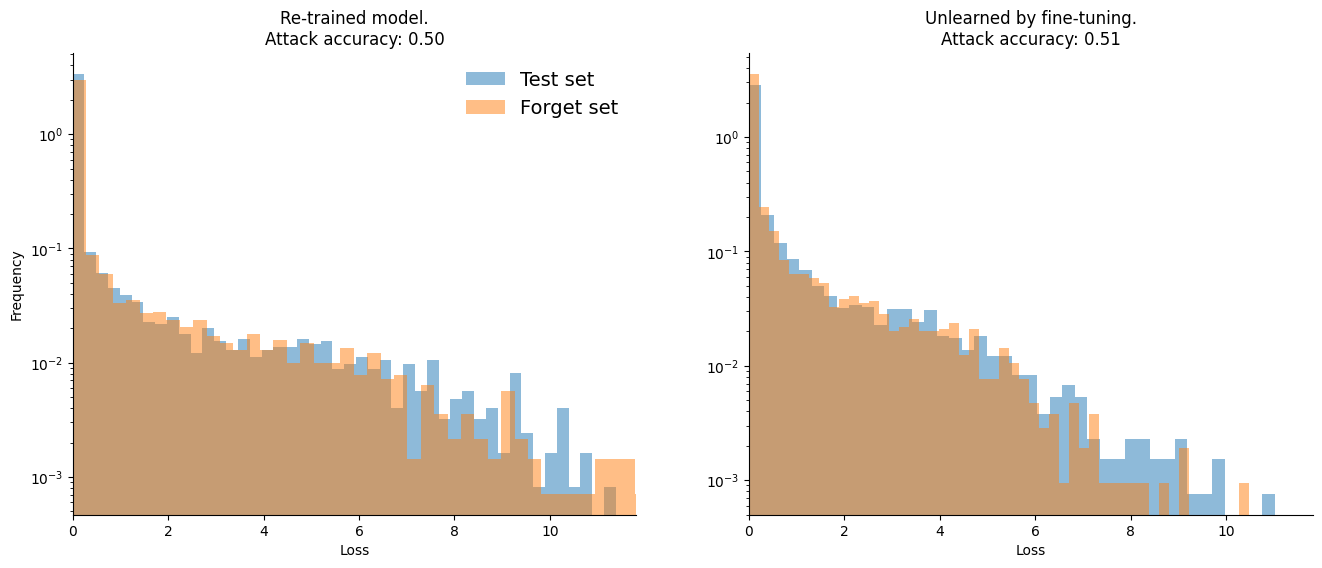

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()